In [416]:
import datetime

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az
from scipy import stats
import math

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.patheffects as path_effects
from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [417]:
#colors, source: https://en.wikipedia.org/wiki/Module:Political_party
color_cdu = '#151518'
color_spd = '#E3000F'
color_grn = '#409A3C'
color_fdp = '#FFED00'
color_lnk = '#BE3075'
color_afd = '#00A2DE'
color_bsw = '#E72D71'
color_oth = 'goldenrod'

parties = ['bsw','lnk','grn','spd','oth','cdu','fdp','afd']

parties_wo = ['bsw','lnk','grn','spd','cdu','fdp','afd']
colors_wo = [color_bsw, color_lnk, color_grn, color_spd, color_cdu, color_fdp, color_afd]

In [418]:
df = pd.read_csv("../Data/clean/german_polls.csv")

In [419]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

In [420]:
df['date'] = (df['start_date'] + (df['end_date'] - df['start_date']) / 2).dt.round('D')

In [421]:
df = df[df['date'] > '2021-09-26'] #Only polls since preceding election
df['week'] = (df['date'] - pd.Timestamp('2025-02-23')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2025-02-23')).dt.days

df = df.set_index('date')

In [422]:
df['year'] = df.index.year
df['month'] = df.index.month

In [423]:
df = df[['pollster', 'methodology', 'sample_size', 'week', 'day', 'cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw']] #competitive parties in this election
df['oth'] = 100 - df[['cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw']].sum(axis=1)
df[['cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw', 'oth']] = df[['cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw', 'oth']].div(100)

#df = df.dropna()
df['obs_id'] = range(len(df))

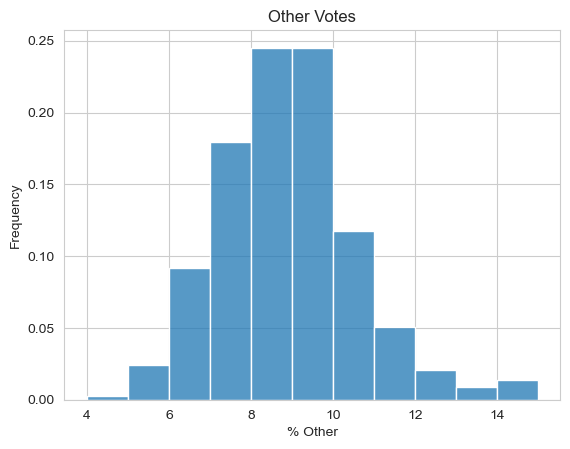

In [424]:
bin_width = 1
max_value = (100 * df.oth).max()
min_value = (100 * df.oth).min()
bins = int((max_value - min_value) / bin_width)

sns.histplot(100 * df.oth, bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Other Votes')

plt.savefig('other_performance.png')

In [425]:
df = df.query("oth > 0")

In [426]:
df[['cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw']].describe()

cdu         spd         grn         fdp         lnk         afd  \
count  869.000000  869.000000  869.000000  869.000000  846.000000  869.000000   
mean     0.280213    0.190161    0.157727    0.070299    0.043641    0.156064   
std      0.030516    0.037659    0.033989    0.025356    0.009705    0.040669   
min      0.185000    0.130000    0.090000    0.030000    0.020000    0.070000   
25%      0.265000    0.160000    0.130000    0.050000    0.040000    0.120000   
50%      0.280000    0.180000    0.150000    0.070000    0.045000    0.160000   
75%      0.300000    0.210000    0.180000    0.080000    0.050000    0.190000   
max      0.370000    0.285000    0.260000    0.160000    0.080000    0.240000   

              bsw  
count  233.000000  
mean     0.068670  
std      0.015925  
min      0.030000  
25%      0.060000  
50%      0.070000  
75%      0.080000  
max      0.100000

In [427]:
df.head(20)

pollster              methodology  sample_size  week  \
date                                                                        
2025-01-12               INSA             Online Panel         2005    -6   
2025-01-08  Forsch'gr. Wahlen         Live Phone / SMS         1433    -7   
2025-01-08               INSA  Online Panel/Live Phone         1205    -7   
2025-01-07    Infratest dimap               Live Phone         1323    -7   
2025-01-04             YouGov             Online Panel         1908    -8   
2025-01-04               INSA             Online Panel         2001    -8   
2025-01-04              Forsa               Live Phone         1501    -8   
2025-01-01               INSA  Online Panel/Live Phone         1201    -8   
2024-12-30                GMS               Live Phone         1010    -8   
2024-12-29               INSA             Online Panel         2004    -8   
2024-12-25               INSA             Online Panel         1002    -9   
2024-12-21               INSA             Online Panel         2010   -10   
2024-12-19              Forsa               Live Phone         2008   -10   
2024-12-18  Forsch'gr. Wahlen         Live Phone / SMS         1362   -10   
2024-12-17               INSA  Online Panel/Live Phone         1205   -10   
2024-12-17    Infratest dimap               Live Phone         1336   -10   
2024-12-15               INSA             Online Panel         2002   -10   
2024-12-14             Verian               Live Phone         1452   -11   
2024-12-13              Forsa               Live Phone         2501   -11   
2024-12-11               INSA  Online Panel/Live Phone         1203   -11   

            day    cdu    spd    grn    fdp    lnk    afd    bsw    oth  \
date                                                                      
2025-01-12  -42  0.310  0.150  0.130  0.040  0.035  0.220  0.065  0.050   
2025-01-08  -46  0.300  0.140  0.150  0.040  0.040  0.210  0.040  0.080   
2025-01-08  -46  0.300  0.160  0.130  0.040  0.030  0.220  0.060  0.060   
2025-01-07  -47  0.310  0.150  0.140  0.040  0.040  0.200  0.050  0.070   
2025-01-04  -50  0.290  0.160  0.140  0.050  0.030  0.210  0.060  0.060   
2025-01-04  -50  0.310  0.155  0.135  0.040  0.030  0.215  0.065  0.050   
2025-01-04  -50  0.320  0.170  0.120  0.030  0.030  0.190  0.040  0.100   
2025-01-01  -53  0.310  0.160  0.130  0.040  0.030  0.200  0.070  0.060   
2024-12-30  -55  0.330  0.160  0.130  0.040  0.030  0.180  0.040  0.090   
2024-12-29  -56  0.310  0.165  0.120  0.035  0.040  0.205  0.070  0.055   
2024-12-25  -60  0.310  0.170  0.120  0.040  0.030  0.200  0.070  0.060   
2024-12-21  -64  0.310  0.160  0.125  0.050  0.030  0.195  0.080  0.050   
2024-12-19  -66  0.310  0.160  0.130  0.030  0.040  0.190  0.040  0.100   
2024-12-18  -67  0.310  0.150  0.140  0.030  0.040  0.190  0.050  0.090   
2024-12-17  -68  0.320  0.160  0.120  0.050  0.030  0.200  0.080  0.040   
2024-12-17  -68  0.330  0.140  0.140  0.030  0.030  0.190  0.050  0.090   
2024-12-15  -70  0.315  0.165  0.115  0.050  0.025  0.195  0.080  0.055   
2024-12-14  -71  0.310  0.170  0.140  0.040  0.030  0.180  0.050  0.080   
2024-12-13  -72  0.300  0.170  0.130  0.040  0.030  0.190  0.040  0.100   
2024-12-11  -74  0.310  0.170  0.110  0.050  0.030  0.200  0.080  0.050   

            obs_id  
date                
2025-01-12       0  
2025-01-08       1  
2025-01-08       2  
2025-01-07       3  
2025-01-04       4  
2025-01-04       5  
2025-01-04       6  
2025-01-01       7  
2024-12-30       8  
2024-12-29       9  
2024-12-25      10  
2024-12-21      11  
2024-12-19      12  
2024-12-18      13  
2024-12-17      14  
2024-12-17      15  
2024-12-15      16  
2024-12-14      17  
2024-12-13      18  
2024-12-11      19

In [428]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(20).index.values

In [429]:
df.groupby("pollster").obs_id.count()

pollster
Allensbach            39
Forsa                165
Forsch'gr. Wahlen     62
GMS                   26
INSA                 342
Infratest dimap       69
Verian               127
YouGov                39
Name: obs_id, dtype: int64

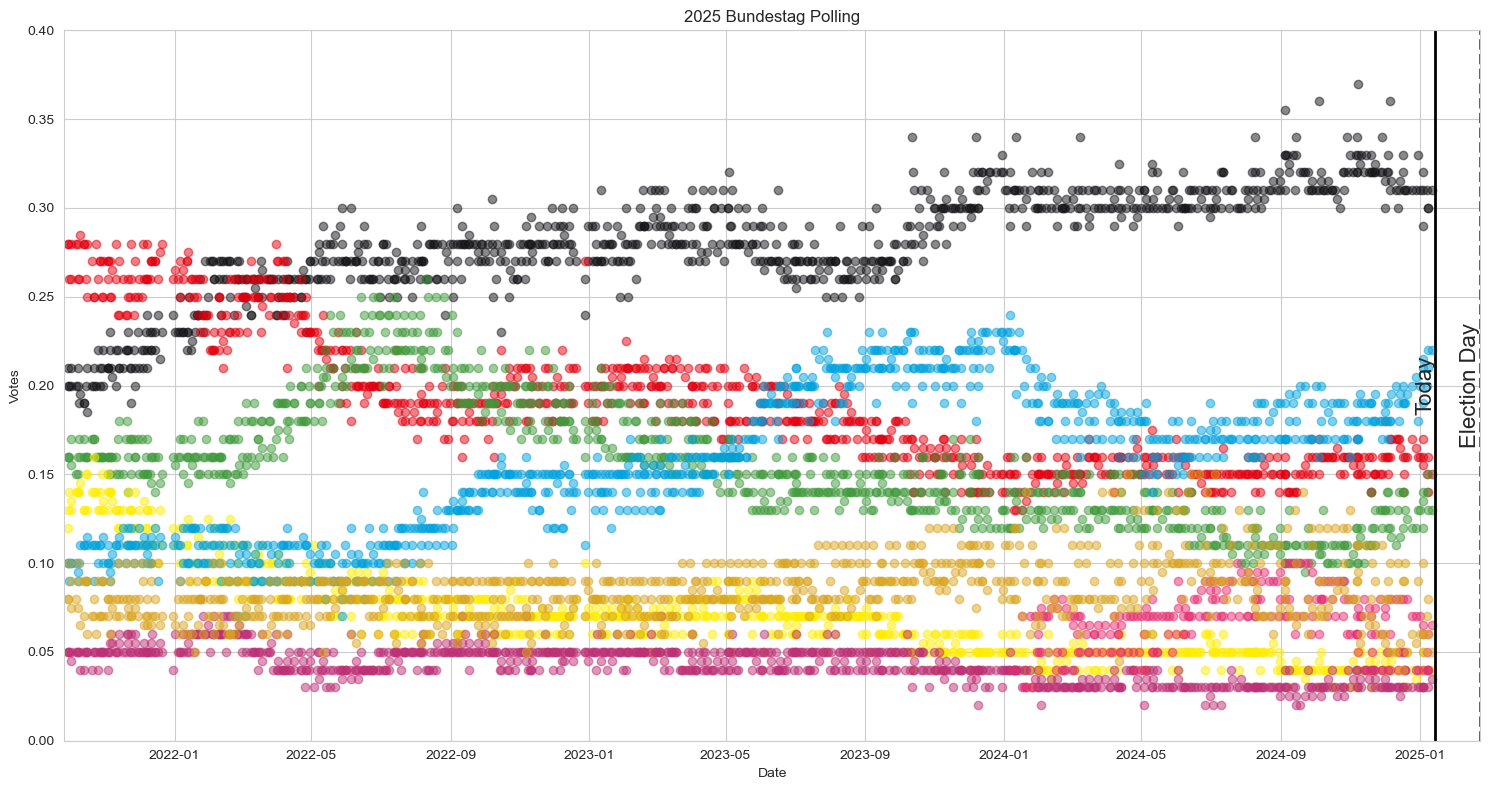

In [430]:
cdu_votes = df.cdu.values
spd_votes = df.spd.values
grn_votes = df.grn.values
fdp_votes = df.fdp.values
lnk_votes = df.lnk.values
afd_votes = df.afd.values
bsw_votes = df.bsw.values

oth_votes = df.oth.values

dates = df.index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, cdu_votes, "o", alpha=0.5, color=color_cdu, label="CDU/CSU")
ax.plot(dates, spd_votes, "o", alpha=0.5, color=color_spd, label="SPD")
ax.plot(dates, grn_votes, "o", alpha=0.5, color=color_grn, label="GRÜNE")
ax.plot(dates, fdp_votes, "o", alpha=0.5, color=color_fdp, label="FDP")
ax.plot(dates, lnk_votes, "o", alpha=0.5, color=color_lnk, label="LINKE")
ax.plot(dates, afd_votes, "o", alpha=0.5, color=color_afd, label="AfD")
ax.plot(dates, bsw_votes, "o", alpha=0.5, color=color_bsw, label="BSW")
ax.plot(dates, oth_votes, "o", alpha=0.5, color=color_oth, label="Other")

# Set limits and labels
ax.set_ylim(0, 0.4)
ax.set_xlim(dt.datetime(2021, 9, 26), dt.datetime(2025, 2, 23))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2025 Bundestag Polling')

events = [
            (dt.datetime(2025, 2, 23), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.2, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.2, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, '30-Day Rolling National Polling Standard Deviation')

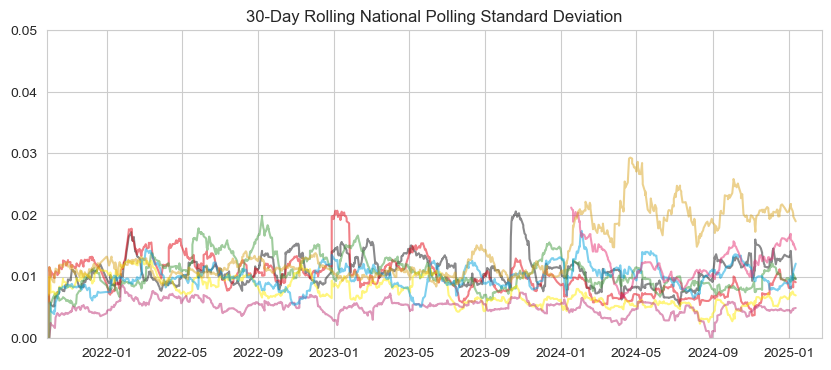

In [431]:
rolling_std = (
    df[['cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw', "oth"]]
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .std()
    .reset_index()[["date", 'cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw', "oth"]]
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.cdu.values,
    color = color_cdu,
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.spd.values,
    color = color_spd,
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.grn.values,
    color = color_grn,
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.fdp.values,
    color = color_fdp,
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.lnk.values,
    color = color_lnk,
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.afd.values,
    color = color_afd,
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.bsw.values,
    color = color_bsw,
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.oth.values,
    color = color_oth,
    alpha=0.5,
)

ax.set_ylim(0, .05)
ax.set_xlim(dt.datetime(2021, 9, 26), dt.datetime(2025, 2, 23))
ax.set_title("30-Day Rolling National Polling Standard Deviation")

Text(0.5, 1.0, '7-Day Rolling National Polling Mean')

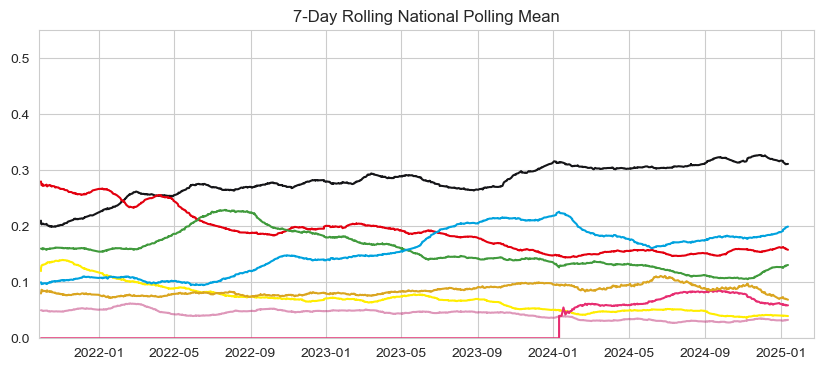

In [439]:
rolling_mean = (
    df[['cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw', "oth"]]
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .mean()
    .reset_index()[["date", 'cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw', "oth"]]
    .fillna(0)
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.cdu.values,
    color = color_cdu,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.spd.values,
    color = color_spd,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.grn.values,
    color = color_grn,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.fdp.values,
    color = color_fdp,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.lnk.values,
    color = color_lnk,
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.afd.values,
    color = color_afd,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.bsw.values,
    color = color_bsw,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.oth.values,
    color = color_oth,
)

ax.set_ylim(0, .55)
ax.set_xlim(dt.datetime(2021, 9, 26), dt.datetime(2025, 2, 23))
ax.set_title("7-Day Rolling National Polling Mean")

In [433]:
rolling_mean[parties].diff().corr()

bsw       lnk       grn       spd       oth       cdu       fdp  \
bsw  1.000000 -0.008203 -0.177163 -0.063536 -0.335284  0.045140  0.071604   
lnk -0.008203  1.000000 -0.083480 -0.009952 -0.129434 -0.146389 -0.188135   
grn -0.177163 -0.083480  1.000000 -0.198477  0.011901 -0.101886 -0.363723   
spd -0.063536 -0.009952 -0.198477  1.000000 -0.212462 -0.390598  0.179513   
oth -0.335284 -0.129434  0.011901 -0.212462  1.000000 -0.127287 -0.221759   
cdu  0.045140 -0.146389 -0.101886 -0.390598 -0.127287  1.000000 -0.115732   
fdp  0.071604 -0.188135 -0.363723  0.179513 -0.221759 -0.115732  1.000000   
afd  0.131888  0.041461 -0.310581 -0.270531 -0.214388 -0.161911 -0.054614   

          afd  
bsw  0.131888  
lnk  0.041461  
grn -0.310581  
spd -0.270531  
oth -0.214388  
cdu -0.161911  
fdp -0.054614  
afd  1.000000

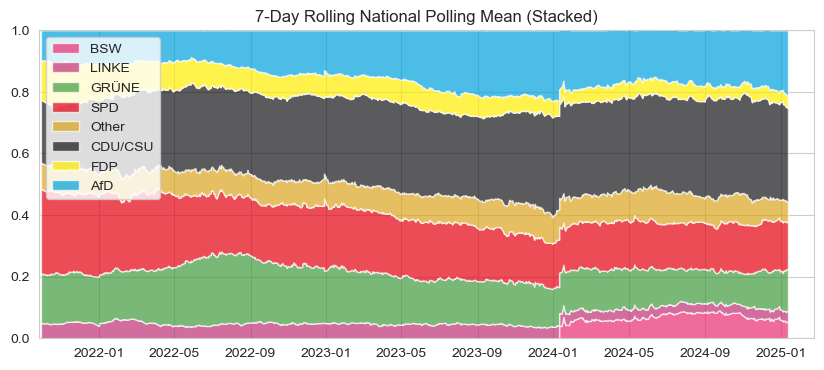

In [434]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean.date,
    rolling_mean.bsw.values,
    rolling_mean.lnk.values,
    rolling_mean.grn.values,
    rolling_mean.spd.values,
    rolling_mean.oth.values,
    rolling_mean.cdu.values,
    rolling_mean.fdp.values,
    rolling_mean.afd.values,
    labels=['BSW','LINKE','GRÜNE','SPD','Other','CDU/CSU','FDP','AfD'],
    colors=[color_bsw, color_lnk, color_grn, color_spd, color_oth, color_cdu, color_fdp, color_afd],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2021, 9, 26), dt.datetime(2025, 2, 23))
ax.set_title("7-Day Rolling National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.show()

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_30907/3192763321.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rolling_mean2 = rolling_mean[['bsw','lnk','grn','spd','cdu','fdp','afd']].applymap(lambda x: 0 if x < 0.05 else x)


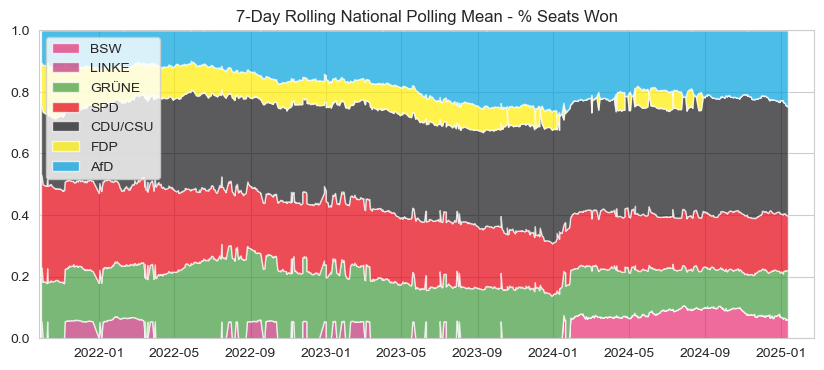

In [435]:
rolling_mean2 = rolling_mean[['bsw','lnk','grn','spd','cdu','fdp','afd']].applymap(lambda x: 0 if x < 0.05 else x)
rolling_mean2['date'] = rolling_mean.date
rolling_mean2[['bsw','lnk','grn','spd','cdu','fdp','afd']] = np.array(rolling_mean2[['bsw','lnk','grn','spd','cdu','fdp','afd']]) / \
             np.array(rolling_mean2[['bsw','lnk','grn','spd','cdu','fdp','afd']].sum(axis=1)).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean2.date,
    rolling_mean2.bsw.values,
    rolling_mean2.lnk.values,
    rolling_mean2.grn.values,
    rolling_mean2.spd.values,
    rolling_mean2.cdu.values,
    rolling_mean2.fdp.values,
    rolling_mean2.afd.values,

    labels=['BSW','LINKE','GRÜNE','SPD','CDU/CSU','FDP','AfD'],
    colors=[color_bsw, color_lnk, color_grn, color_spd, color_cdu, color_fdp, color_afd],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2021, 9, 26), dt.datetime(2025, 2, 23))
ax.set_title("7-Day Rolling National Polling Mean - % Seats Won")
ax.legend(loc='upper left')

plt.show()

In [436]:
date_counts = df.reset_index()['date'].value_counts().reset_index()

# Rename the columns
date_counts.columns = ['date', 'count']

# Sort the DataFrame by date in descending order
date_counts = date_counts.sort_values(by='date', ascending=False).reset_index(drop=True)

In [437]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

#day_id, day = df.set_index(["day"]).index.factorize(sort=True)
day_id = df.day.to_numpy()
day = np.arange(df.day.min(), 1)

party_id, party, party_colors = [0,1,2,3,4,5,6,7], ['bsw','lnk','grn','spd','oth','cdu','fdp','afd'], [color_bsw, color_lnk, color_grn, color_spd, color_oth, color_cdu, color_fdp, color_afd]

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "party": party,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [438]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # Small positive number
    num_parties = len(parties)
    
    # Covariance matrix for the multivariate random walk
    chol_cov, corr, stds = pm.LKJCholeskyCov(
    "chol_cov", eta=2.0, n=num_parties, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
        )
    
    # Compute the full covariance matrix
    Sigma = pm.Deterministic("Sigma", chol_cov @ chol_cov.T)
                    
    # Multivariate random walk
    multivariate_rw = pm.MvGaussianRandomWalk(
        "multivariate_rw",
        mu=np.zeros(num_parties),  # Initial mean (zeros)
        cov=Sigma,
        init_dist=pm.MvNormal.dist(mu=np.zeros(num_parties), cov=np.eye(num_parties)),
        dims=("day", "party")
    )
    
    # Loop over parties
    for i, party in enumerate(parties):
        sigma = pm.HalfNormal(f"{party}_sigma", sigma=0.1) + epsilon
        rho = pm.Normal(f"{party}_rho", mu=0, sigma=0.7)
        ar = pm.AR(f"{party}_ar",
                   rho=[rho] * 14,
                   sigma=sigma,
                   init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                   dims="day"
                  )

        # Momentum Factor: Slope of recent polling data
        momentum_decay = pm.Exponential(f"{party}_momentum_decay", lam=0.05)
        momentum_factor = pm.Normal(f"{party}_momentum_factor", mu=1, sigma=0.2)
        recent_days = 14  # Number of days to calculate momentum

        # Extract the corresponding random walk for this party
        random_walk = multivariate_rw[:, i]

        # Shift random_walk by recent_days to compute differences
        random_walk_shifted = pm.math.concatenate([
            pm.math.zeros(recent_days), random_walk[:-recent_days]
        ])
        trend = pm.Deterministic(
            f"{party}_momentum",
            (random_walk - random_walk_shifted) / recent_days,
            dims="day"
        )
        momentum = pm.Deterministic(
            f"{party}_momentum_effect",
            trend * momentum_decay * momentum_factor,
            dims="day"
        )

        # Combined day effect with momentum
        day_effect = pm.Deterministic(
            f"{party}_day_effect", ar + random_walk + momentum, dims="day"
        )

        pollster_effect = pm.Normal(f"{party}_pollster_effect", 0, 0.5, dims="pollster")

        polling = pm.Deterministic(f"{party}_polling", pm.math.invlogit(
            pollster_effect[pollster_id] +
            day_effect[day_id]
        ),
            dims="observation")

        # Binomial likelihoods
        vote = pm.Binomial(
            f"{party}_vote",
            p=polling,
            n=df["sample_size"],
            observed=df['sample_size'] * df[f"{party}"],
            dims="observation",
        )

    # Sampling
    idata = pm.sample(draws=1000, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:1352: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in bsw_vote contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:1352: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in lnk_vote contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling 

Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 12174 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 4 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 8 re

In [440]:
import arviz as az
# Save the idata to a file
az.to_netcdf(idata, 'jan14.nc')

'jan14.nc'

In [441]:
#loaded_idata = az.from_netcdf('twoway_model_trace.nc')

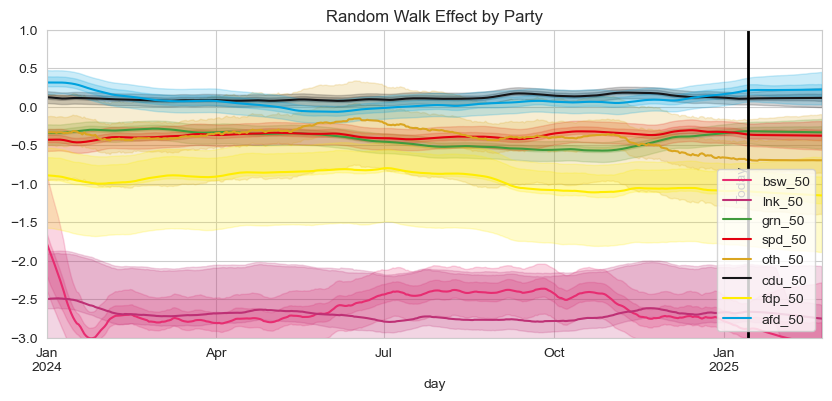

In [442]:
rw = pd.DataFrame()
rw['day'] = pd.date_range(start=df.index.min(), end='2025-02-23')

for party in parties:
    rw[f"{party}_50"] = idata.posterior[f"{party}_day_effect"].median(dim=["chain", "draw"]).values
    rw[[f"{party}_03",f"{party.lower()}_97"]] = az.hdi(idata.posterior[f"{party}_day_effect"], hdi_prob=0.94)[f"{party}_day_effect"]
    rw[[f"{party}_25",f"{party.lower()}_75"]] = az.hdi(idata.posterior[f"{party}_day_effect"], hdi_prob=0.50)[f"{party}_day_effect"]

rw = rw.set_index('day')

rolling_mean = (
    rw
    .rolling(window='7D')
    .mean()
)

fig, ax = plt.subplots(figsize=(10, 4))

for party, color in zip(parties, party_colors):
    
    rolling_mean[f"{party}_50"].plot(color=color)
    plt.fill_between(rw.index, rolling_mean[f"{party.lower()}_03"].ffill(), rolling_mean[f"{party.lower()}_97"].ffill(), color=color, alpha=0.2)
    plt.fill_between(rw.index, rolling_mean[f"{party.lower()}_25"].ffill(), rolling_mean[f"{party.lower()}_75"].ffill(), color=color, alpha=0.2)
    
ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), -1, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2025, 2, 23))
ax.set_ylim(-3,1)
ax.set_title("Random Walk Effect by Party")
ax.legend()

plt.show()

In [443]:
interim = pd.DataFrame()

for party in parties:
    pollster_effects = (
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Allensbach") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Forsa") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Forsch'gr. Wahlen") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="GMS") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="INSA") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Infratest dimap") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Verian") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov")
    ).values / 8
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"]

In [474]:
df_day_03.tail(415)

index       bsw       lnk       grn       spd       oth       cdu  \
date                                                                            
2024-01-06   -414  0.057563  0.032523  0.114213  0.125907  0.075934  0.269824   
2024-01-07   -413  0.054989  0.033075  0.115788  0.127614  0.078121  0.274018   
2024-01-08   -412  0.051664  0.032726  0.118464  0.128533  0.076788   0.27911   
2024-01-09   -411  0.048865   0.03302  0.120336  0.129365  0.077461  0.283591   
2024-01-10   -410  0.046319  0.033359  0.122211  0.129788  0.078029  0.287757   
...           ...       ...       ...       ...       ...       ...       ...   
2025-02-19     -4  0.020561  0.025077  0.119451  0.137378  0.054803  0.295143   
2025-02-20     -3  0.020264  0.024989   0.11926   0.13708  0.054857  0.294771   
2025-02-21     -2  0.019963  0.024886  0.119041  0.136863  0.054621    0.2951   
2025-02-22     -1  0.019723  0.024715  0.118927  0.136623  0.054593  0.294766   
2025-02-23      0  0.019324  0.024737  0.118773  0.136548  0.054491  0.294552   

                 fdp       afd  
date                            
2024-01-06  0.038829  0.190201  
2024-01-07  0.039826   0.19225  
2024-01-08  0.039296  0.194999  
2024-01-09  0.039412  0.197086  
2024-01-10  0.039392  0.199009  
...              ...       ...  
2025-02-19   0.03062  0.187555  
2025-02-20  0.030567  0.187315  
2025-02-21  0.030492  0.187119  
2025-02-22   0.03038  0.187003  
2025-02-23  0.030354   0.18685  

[415 rows x 9 columns]

In [491]:
# Make BSW 0 if before 8 January 2024

df_results = pd.DataFrame(columns=parties)
df_day_mean = pd.DataFrame(index=day, columns=parties)
df_day_03 =  pd.DataFrame(index=day, columns=parties)
df_day_25 =  pd.DataFrame(index=day, columns=parties)
df_day_75 =  pd.DataFrame(index=day, columns=parties)
df_day_97 =  pd.DataFrame(index=day, columns=parties)

for d in tqdm(day):
    day_results = {}
    for party in parties:
        if (d < -412 and party == "bsw"):
            day_results[f"{party}"] = 0
        else:
            day_results[f"{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                (idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
                )  
            ).to_numpy()

    # Calculate total votes and normalize
    total = sum(day_results[f"{party}"] for party in parties)
    for party in parties:
        day_results[f"{party}"] /= total

    # Convert day_results to DataFrame
    df_results = pd.DataFrame(day_results)

    # Store quantiles and mean for this day
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|██████████████████████████████████████| 1244/1244 [00:08<00:00, 150.00it/s]


In [492]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.index.min(), end='2025-02-23')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')

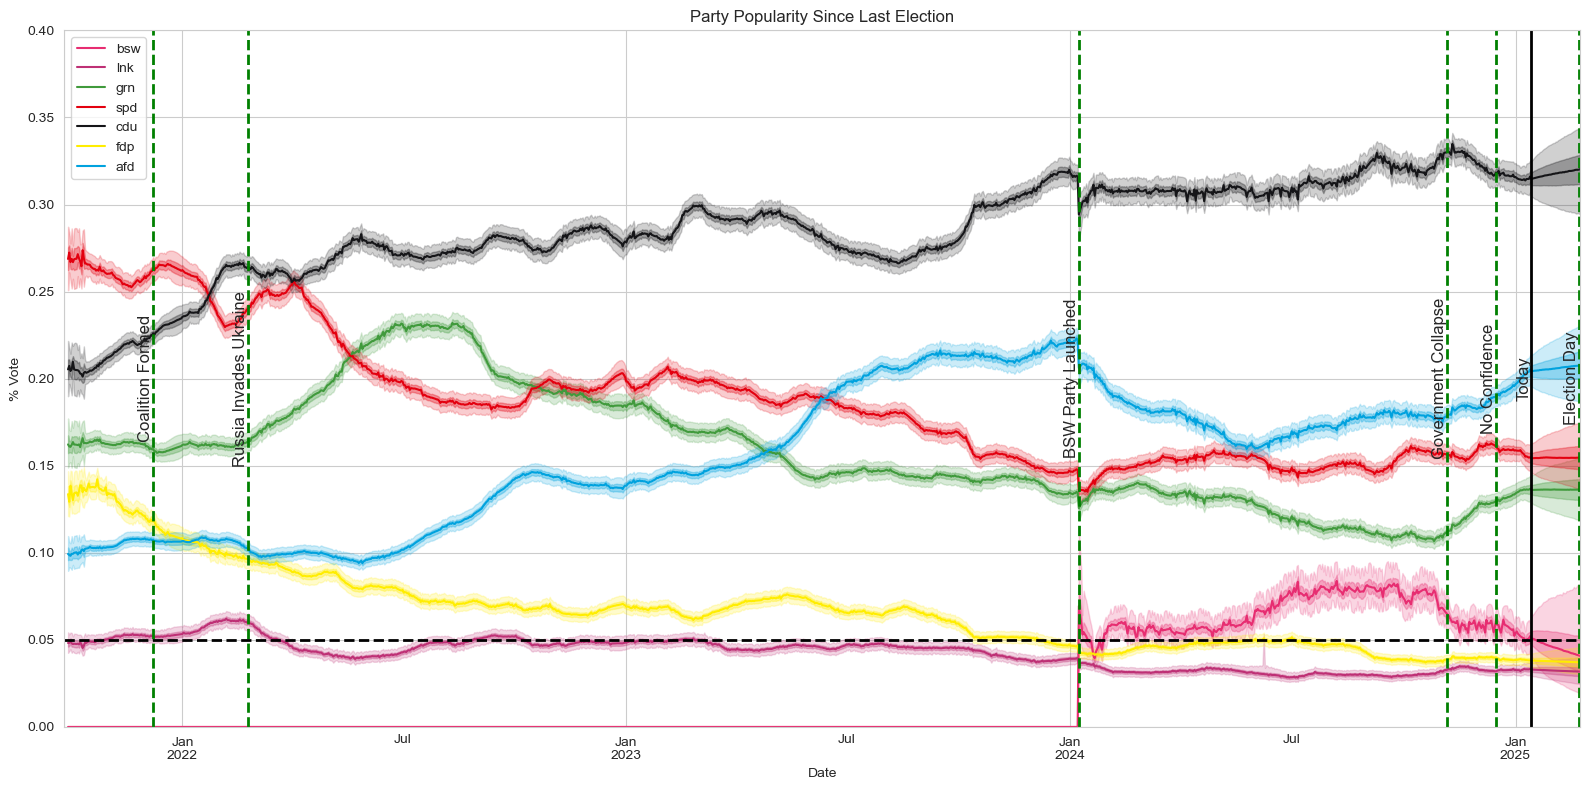

In [571]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plotting dem_votes and gop_votes on the same axes

for party, color in zip(parties_wo, colors_wo):
    df_day_mean[f"{party}"].rolling(window='1D').mean().plot(color=color, label= f'{party}')
    plt.fill_between(df_day_97.index, df_day_03[f"{party}"].rolling(window='1D').mean().ffill(), df_day_97[f"{party}"].rolling(window='1D').mean().ffill(), color=color, alpha=0.2)
    plt.fill_between(df_day_75.index, df_day_25[f"{party}"].rolling(window='1D').mean().ffill(), df_day_75[f"{party}"].rolling(window='1D').mean().ffill(), color=color, alpha=0.3)

#ax.plot(dates, cdu_votes, "o", alpha=0.5, color=color_cdu, label="CDU/CSU")
#ax.plot(dates, spd_votes, "o", alpha=0.5, color=color_spd, label="SPD")
#ax.plot(dates, grn_votes, "o", alpha=0.5, color=color_grn, label="GRÜNE")
#ax.plot(dates, fdp_votes, "o", alpha=0.5, color=color_fdp, label="FDP")
#ax.plot(dates, lnk_votes, "o", alpha=0.5, color=color_lnk, label="LINKE")
#ax.plot(dates, afd_votes, "o", alpha=0.5, color=color_afd, label="AfD")
#ax.plot(dates, bsw_votes, "o", alpha=0.5, color=color_bsw, label="BSW")

ax.set_ylim(0,.4)
ax.set_xlim(dt.datetime(2021, 9, 26), dt.datetime(2025, 2, 23))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.set_title("Party Popularity Since Last Election")
ax.legend()

events = [
            (dt.datetime(2021, 12, 8), 'Coalition Formed'),
            (dt.datetime(2022, 2, 24), 'Russia Invades Ukraine'),
            (dt.datetime(2024, 1, 8), 'BSW Party Launched'),
            (dt.datetime(2024, 11, 6), 'Government Collapse'),
            (dt.datetime(2024, 12, 16), 'No Confidence'),
            (dt.datetime(2025, 2, 22), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.2, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=12)

ax.axhline(y=.05, color='black', linestyle='--', linewidth=2)
ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.2, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=12)
    
plt.tight_layout()
plt.savefig('polling_since_2021.png')

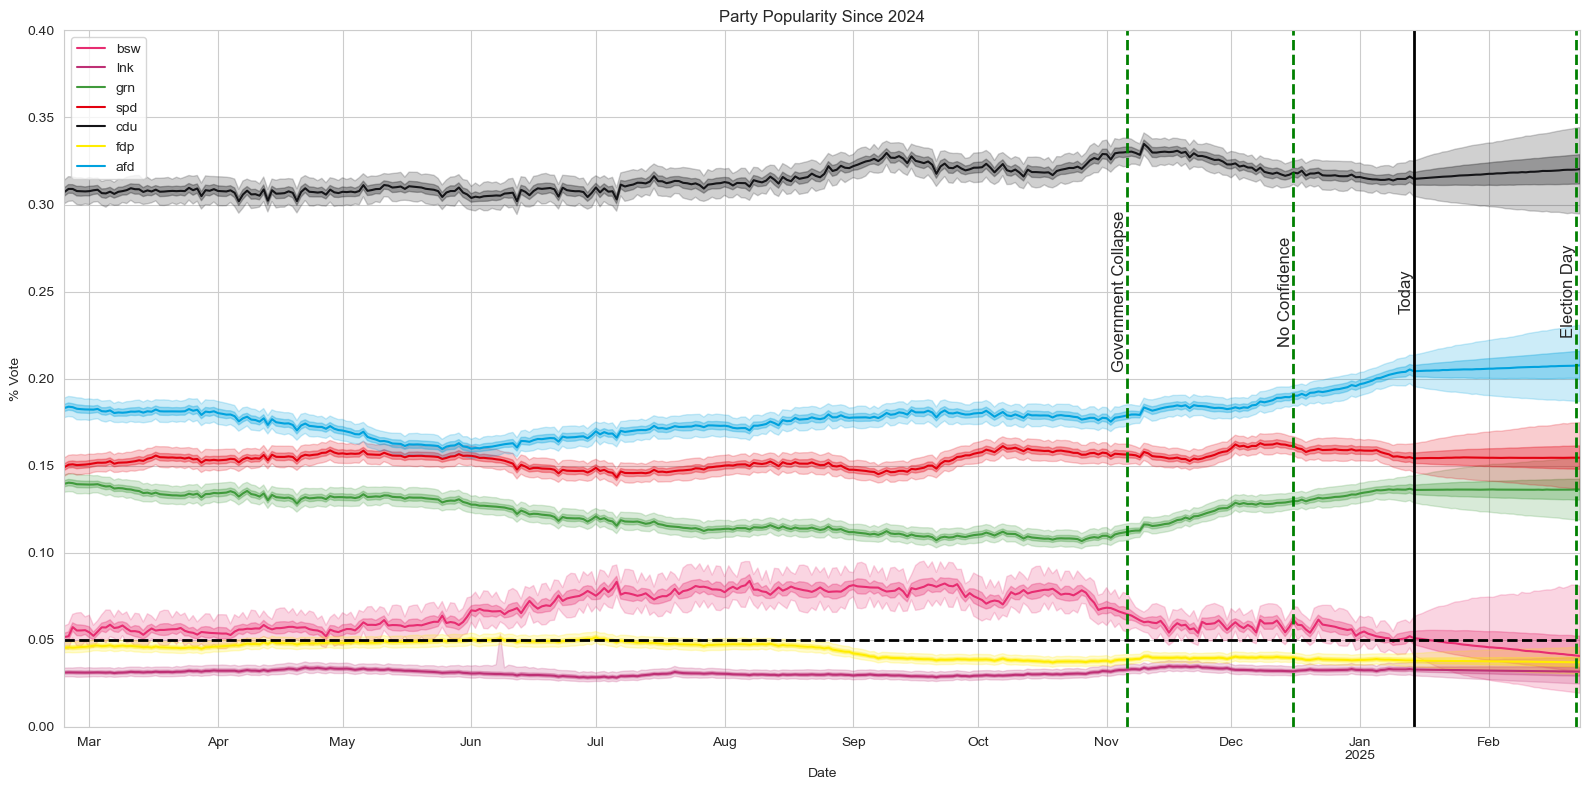

In [574]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plotting dem_votes and gop_votes on the same axes

for party, color in zip(parties_wo, colors_wo):
    df_day_mean[f"{party}"].rolling(window='1D').mean().plot(color=color, label= f'{party}')
    plt.fill_between(df_day_97.index, df_day_03[f"{party}"].rolling(window='1D').mean().ffill(), df_day_97[f"{party}"].rolling(window='1D').mean().ffill(), color=color, alpha=0.2)
    plt.fill_between(df_day_75.index, df_day_25[f"{party}"].rolling(window='1D').mean().ffill(), df_day_75[f"{party}"].rolling(window='1D').mean().ffill(), color=color, alpha=0.3)

#ax.plot(dates, cdu_votes, "o", alpha=0.5, color=color_cdu, label="CDU/CSU")
#ax.plot(dates, spd_votes, "o", alpha=0.5, color=color_spd, label="SPD")
#ax.plot(dates, grn_votes, "o", alpha=0.5, color=color_grn, label="GRÜNE")
#ax.plot(dates, fdp_votes, "o", alpha=0.5, color=color_fdp, label="FDP")
#ax.plot(dates, lnk_votes, "o", alpha=0.5, color=color_lnk, label="LINKE")
#ax.plot(dates, afd_votes, "o", alpha=0.5, color=color_afd, label="AfD")
#ax.plot(dates, bsw_votes, "o", alpha=0.5, color=color_bsw, label="BSW")

ax.set_ylim(0,.4)
ax.set_xlim(dt.datetime(2024, 2, 24), dt.datetime(2025, 2, 23))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.set_title("Party Popularity Since 2024")
ax.legend()

events = [
            (dt.datetime(2024, 11, 6), 'Government Collapse'),
            (dt.datetime(2024, 12, 16), 'No Confidence'),
            (dt.datetime(2025, 2, 22), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=12)

ax.axhline(y=.05, color='black', linestyle='--', linewidth=2)
ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.25, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=12)
    
plt.tight_layout()
plt.savefig('polling_since_2024.png')

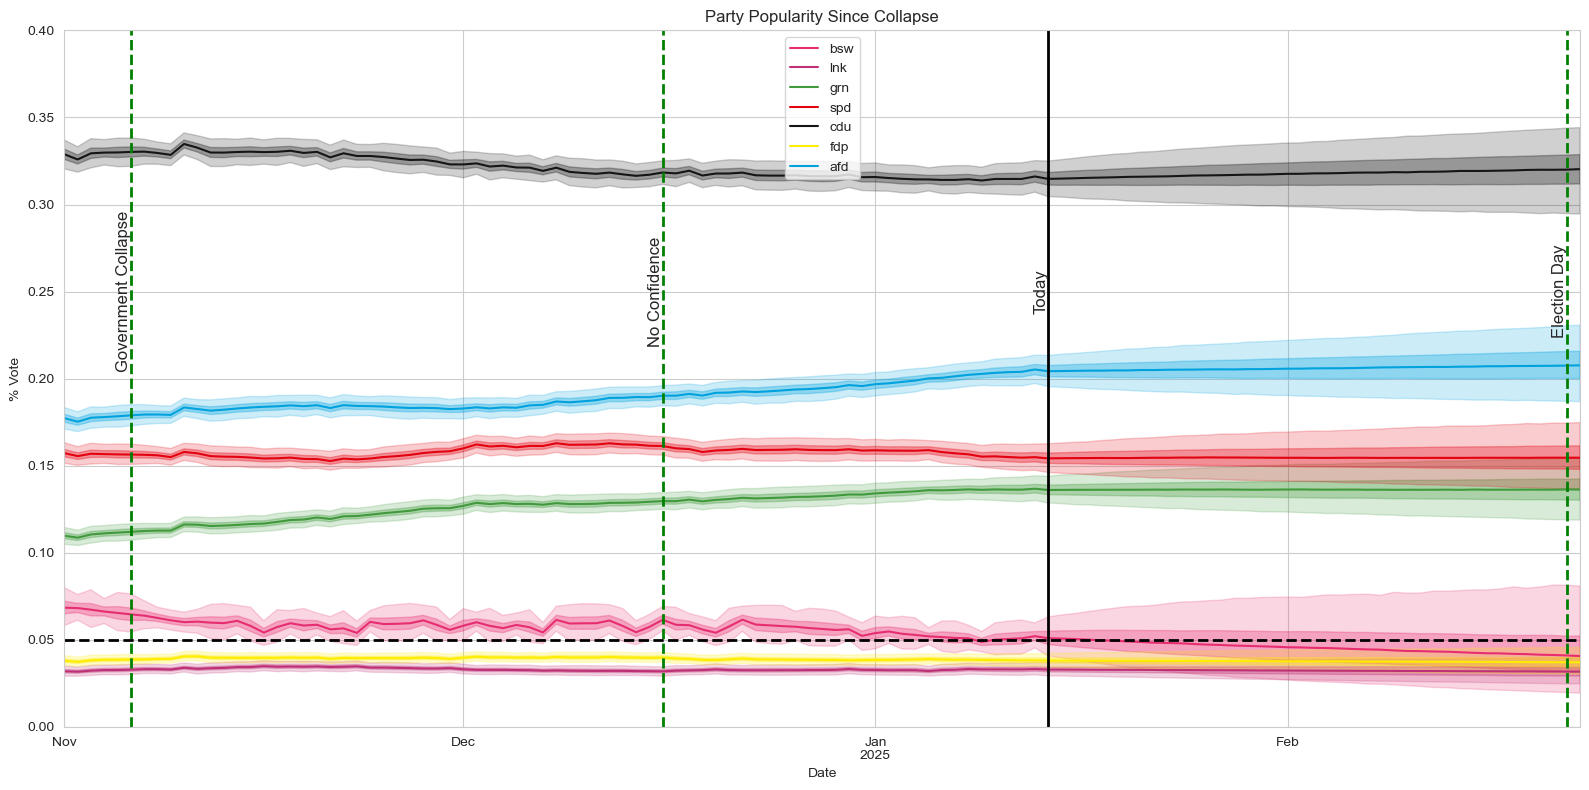

In [575]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plotting dem_votes and gop_votes on the same axes

for party, color in zip(parties_wo, colors_wo):
    df_day_mean[f"{party}"].rolling(window='1D').mean().plot(color=color, label= f'{party}')
    plt.fill_between(df_day_97.index, df_day_03[f"{party}"].rolling(window='1D').mean().ffill(), df_day_97[f"{party}"].rolling(window='1D').mean().ffill(), color=color, alpha=0.2)
    plt.fill_between(df_day_75.index, df_day_25[f"{party}"].rolling(window='1D').mean().ffill(), df_day_75[f"{party}"].rolling(window='1D').mean().ffill(), color=color, alpha=0.3)

#ax.plot(dates, cdu_votes, "o", alpha=0.5, color=color_cdu, label="CDU/CSU")
#ax.plot(dates, spd_votes, "o", alpha=0.5, color=color_spd, label="SPD")
#ax.plot(dates, grn_votes, "o", alpha=0.5, color=color_grn, label="GRÜNE")
#ax.plot(dates, fdp_votes, "o", alpha=0.5, color=color_fdp, label="FDP")
#ax.plot(dates, lnk_votes, "o", alpha=0.5, color=color_lnk, label="LINKE")
#ax.plot(dates, afd_votes, "o", alpha=0.5, color=color_afd, label="AfD")
#ax.plot(dates, bsw_votes, "o", alpha=0.5, color=color_bsw, label="BSW")

ax.set_ylim(0,.4)
ax.set_xlim(dt.datetime(2024, 11, 1), dt.datetime(2025, 2, 23))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.set_title("Party Popularity Since Collapse")
ax.legend()

events = [
            (dt.datetime(2024, 11, 6), 'Government Collapse'),
            (dt.datetime(2024, 12, 16), 'No Confidence'),
            (dt.datetime(2025, 2, 22), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=12)

ax.axhline(y=.05, color='black', linestyle='--', linewidth=2)
ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.25, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=12)
    
plt.tight_layout()
plt.savefig('polling_since_collapse.png')

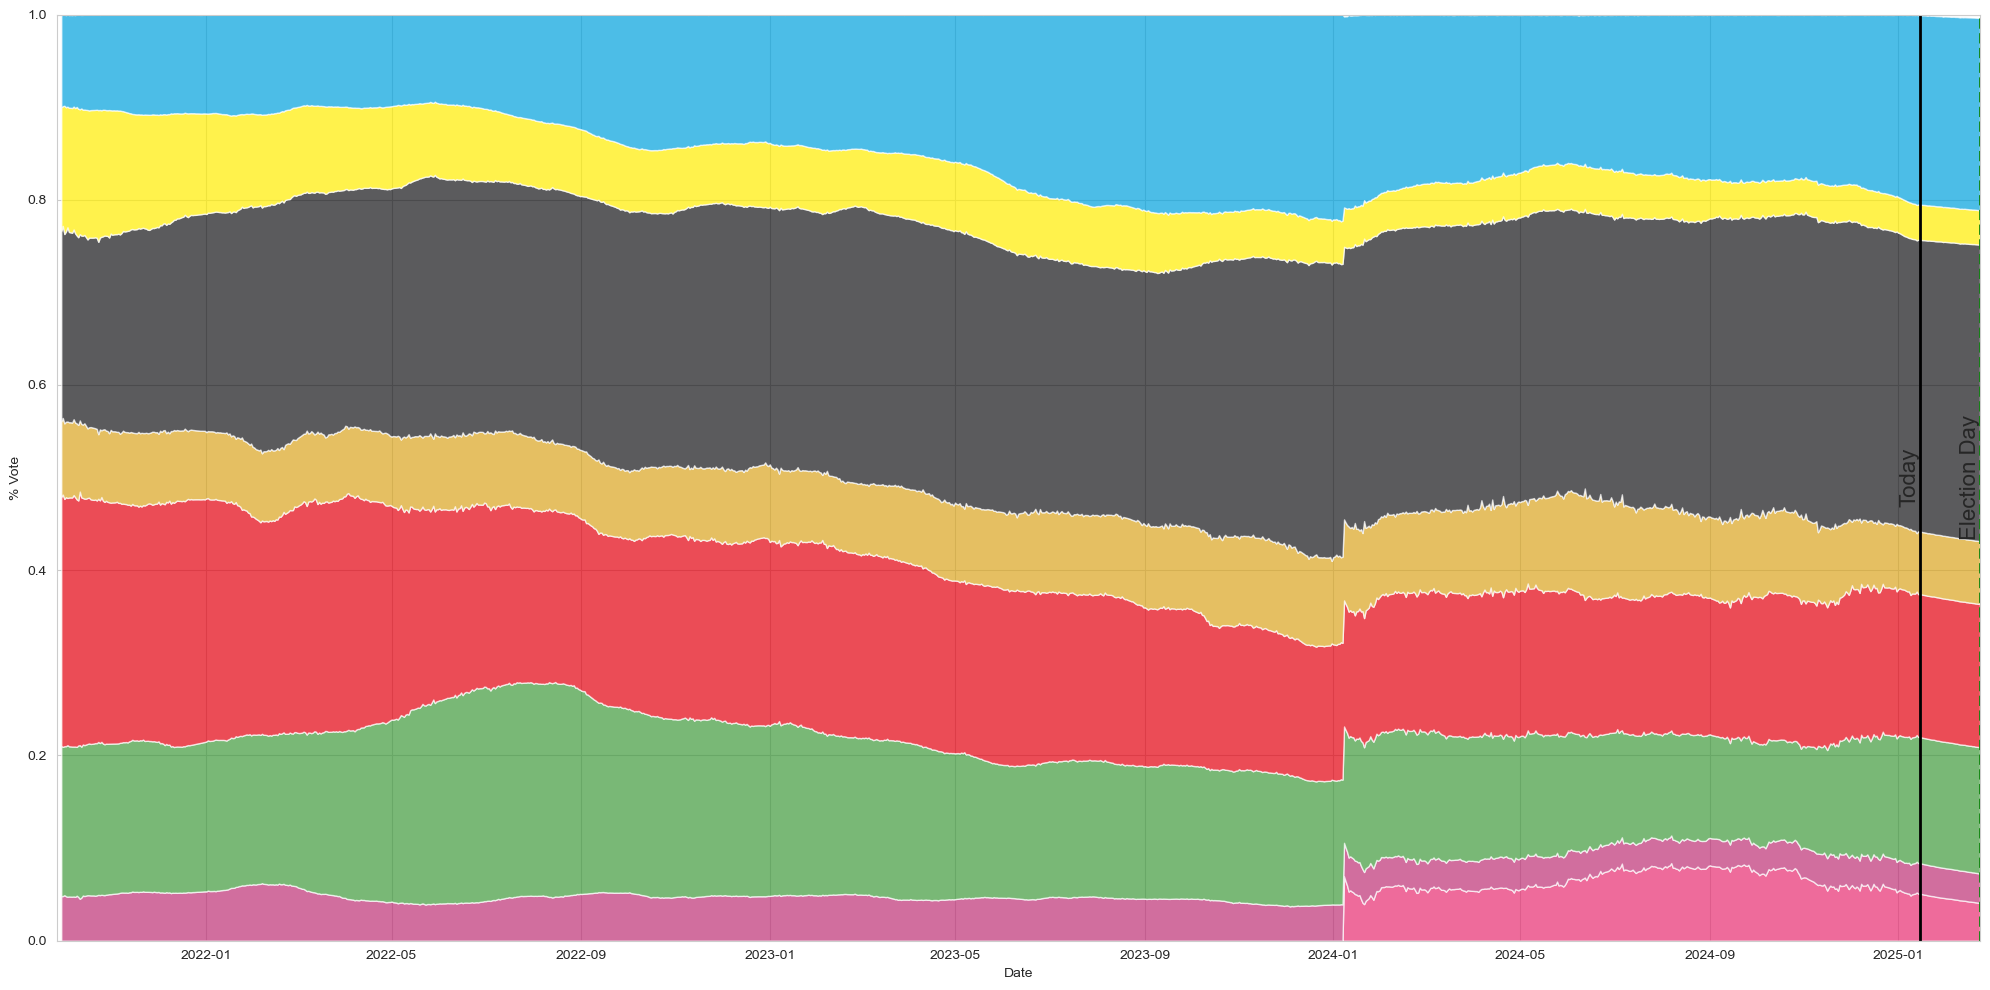

In [505]:
rolling_mean = (
    df_day_mean[parties]
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='1D')
    .mean()
    .reset_index()[["date", 'cdu','spd','grn', 'fdp', 'lnk', 'afd', 'bsw', "oth"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(20, 10))

ax.stackplot(
    rolling_mean.date,
    rolling_mean.bsw.values,
    rolling_mean.lnk.values,
    rolling_mean.grn.values,
    rolling_mean.spd.values,
    rolling_mean.oth.values,
    rolling_mean.cdu.values,
    rolling_mean.fdp.values,
    rolling_mean.afd.values,
    labels=['BSW','LINKE','GRÜNE','SPD','Other','CDU/CSU','FDP','AfD'],
    colors=[color_bsw, color_lnk, color_grn, color_spd, color_oth, color_cdu, color_fdp, color_afd],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2021, 9, 26), dt.datetime(2025, 2, 23))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')

events = [
            (dt.datetime(2025, 2, 23), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.5, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)
    
plt.tight_layout()
plt.savefig('stacked.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_30907/899561856.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rolling_mean2 = rolling_mean[['bsw','lnk','grn','spd','cdu','fdp','afd']].applymap(lambda x: 0 if x < 0.05 else x)


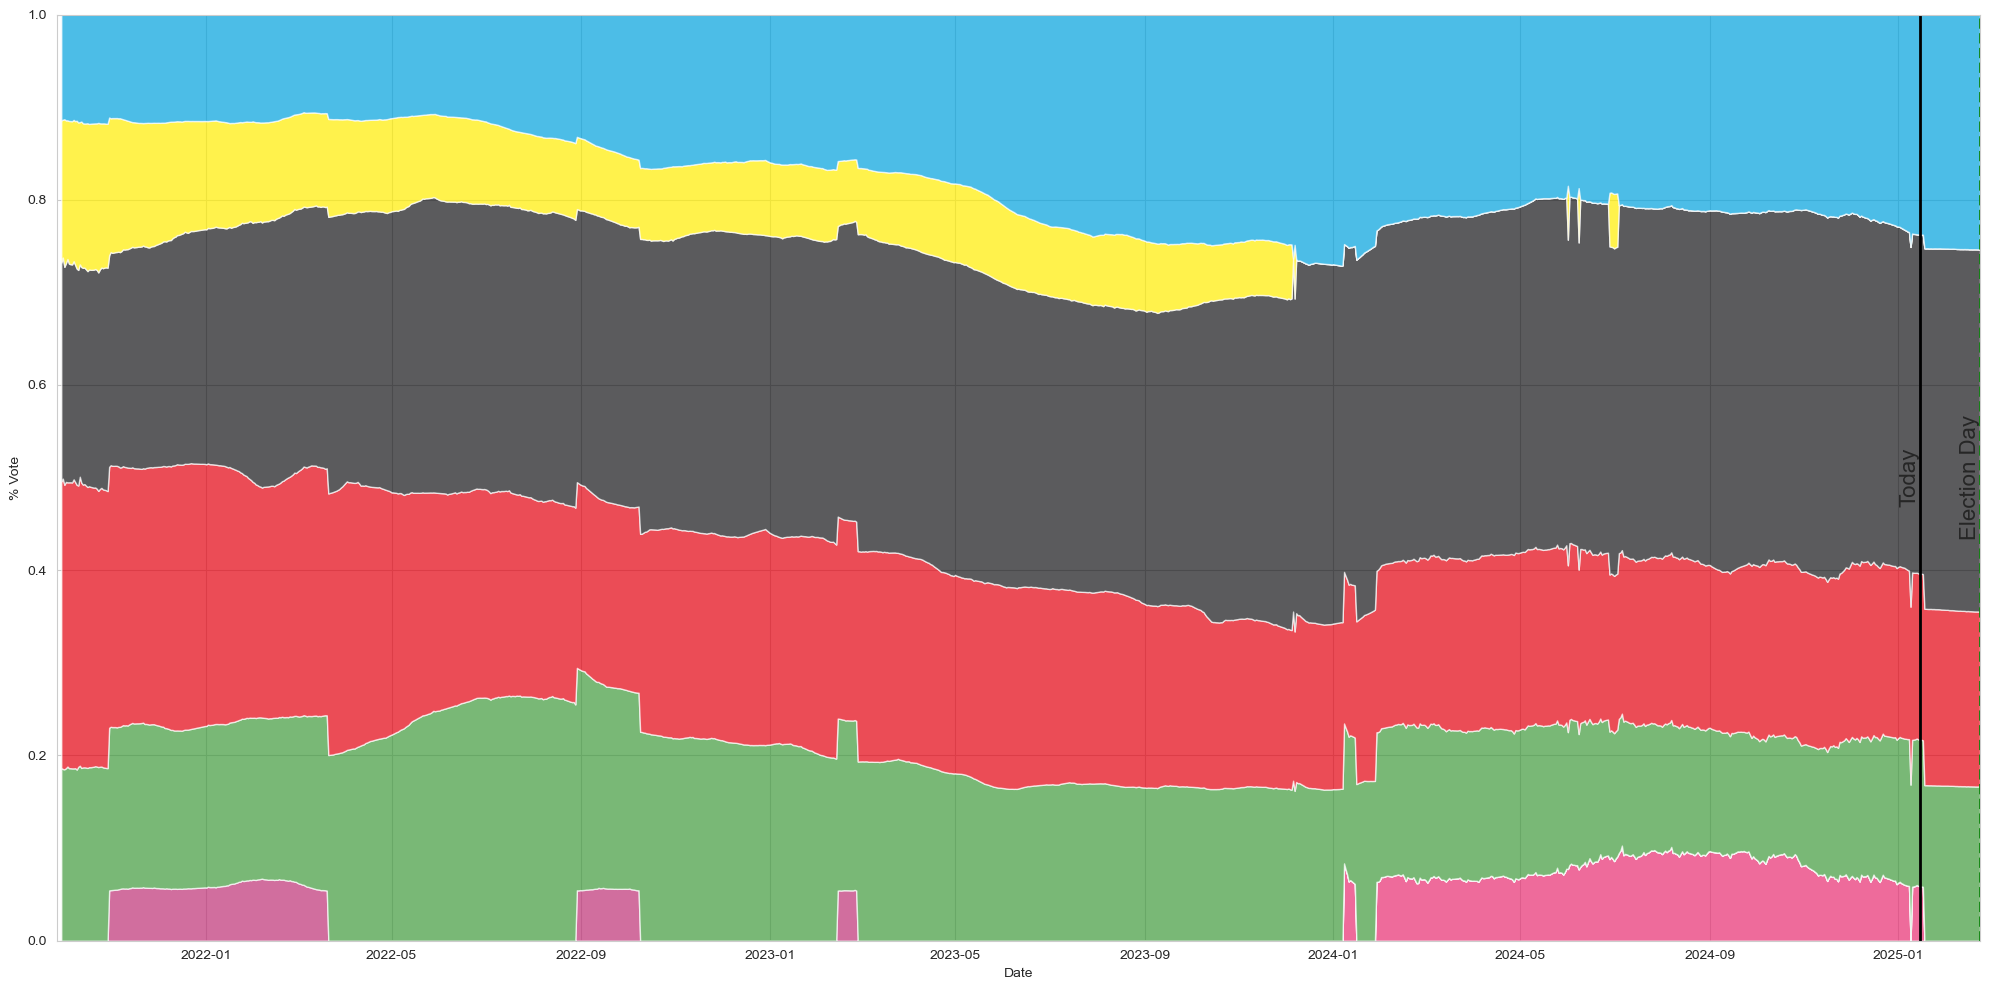

In [506]:
rolling_mean2 = rolling_mean[['bsw','lnk','grn','spd','cdu','fdp','afd']].applymap(lambda x: 0 if x < 0.05 else x)
rolling_mean2['date'] = rolling_mean.date
rolling_mean2[['bsw','lnk','grn','spd','cdu','fdp','afd']] = np.array(rolling_mean2[['bsw','lnk','grn','spd','cdu','fdp','afd']]) / \
             np.array(rolling_mean2[['bsw','lnk','grn','spd','cdu','fdp','afd']].sum(axis=1)).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(20, 10))

ax.stackplot(
    rolling_mean2.date,
    rolling_mean2.bsw.values,
    rolling_mean2.lnk.values,
    rolling_mean2.grn.values,
    rolling_mean2.spd.values,
    rolling_mean2.cdu.values,
    rolling_mean2.fdp.values,
    rolling_mean2.afd.values,
    labels=['BSW','LINKE','GRÜNE','SPD','CDU/CSU','FDP','AfD'],
    colors=[color_bsw, color_lnk, color_grn, color_spd, color_cdu, color_fdp, color_afd],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2021, 9, 26), dt.datetime(2025, 2, 23))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')

events = [
            (dt.datetime(2025, 2, 23), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.5, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)
    
plt.tight_layout()
plt.savefig('stacked.png')

In [507]:
parties

['bsw', 'lnk', 'grn', 'spd', 'oth', 'cdu', 'fdp', 'afd']

In [508]:
rolling_mean

date       cdu       spd       grn       fdp       lnk       afd  \
0    2021-09-29  0.205339  0.268758  0.162235  0.133666  0.048196  0.099337   
1    2021-09-30  0.207371  0.272396  0.161071  0.129304  0.048222  0.098691   
2    2021-10-01  0.204406  0.266943  0.160844  0.138521  0.049192  0.098263   
3    2021-10-02  0.205378  0.268845  0.162029  0.134145  0.048018  0.099412   
4    2021-10-03  0.209710  0.266905  0.163577  0.130235  0.047554  0.099388   
...         ...       ...       ...       ...       ...       ...       ...   
1239 2025-02-19  0.319873  0.154529  0.136288  0.037217  0.031915  0.207283   
1240 2025-02-20  0.319978  0.154599  0.136249  0.037197  0.031835  0.207353   
1241 2025-02-21  0.319965  0.154613  0.136269  0.037159  0.031820  0.207398   
1242 2025-02-22  0.320047  0.154603  0.136370  0.037139  0.031762  0.207510   
1243 2025-02-23  0.320329  0.154616  0.136340  0.037110  0.031766  0.207639   

           bsw       oth  
0     0.000000  0.081715  
1     0.000000  0.082703  
2     0.000000  0.081618  
3     0.000000  0.081477  
4     0.000000  0.082544  
...        ...       ...  
1239  0.041810  0.067750  
1240  0.041475  0.067875  
1241  0.041300  0.067891  
1242  0.041041  0.067874  
1243  0.040726  0.067916  

[1244 rows x 9 columns]

In [509]:
def calculate_seats(results, total_seats, total_votes):

    # Exclude parties with less than 5% of the votes
    eligible_parties = {party: percentage for party, percentage in results.items() if percentage >= .05}
    
    # Convert percentages to vote counts (assuming a total of 1,000,000 votes)
    votes = {party: percentage * total_votes for party, percentage in eligible_parties.items()}
    
    # Initialize seat allocation
    seats = {party: 0 for party in results}
    
    # Create a list to hold the quotients
    quotients = []
    
    # Calculate initial quotients
    for party, vote_count in votes.items():
        quotients.append((vote_count / (2 * seats[party] + 1), party))
    
    # Allocate seats
    for _ in range(total_seats):
        # Sort quotients in descending order
        quotients.sort(reverse=True, key=lambda x: x[0])
        # Allocate a seat to the party with the highest quotient
        highest_quotient, winning_party = quotients.pop(0)
        seats[winning_party] += 1
        # Calculate the new quotient for the party that received the seat
        new_quotient = (votes[winning_party] / (2 * seats[winning_party] + 1), winning_party)
        quotients.append(new_quotient)

    return pd.DataFrame([seats])

In [510]:
df_seats = pd.DataFrame(index=range(len(df_results)), columns=parties_wo)

for i in tqdm(range(len(df_results))):
    seats_df = calculate_seats(df_results[parties_wo].iloc[i].to_dict(), 735, 46298338)
    df_seats.iloc[i] = seats_df.iloc[0].values

df_seats = df_seats.astype('int64')

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1716.95it/s]


In [511]:
df_seats_pct = df_seats.div(df_seats.sum(axis=1), axis=0) * 100

In [512]:
df_seats_pct.mode().iloc[0]

bsw     0.000000
lnk     0.000000
grn    16.326531
spd    18.775510
cdu    38.503401
fdp     0.000000
afd    25.170068
Name: 0, dtype: float64

In [578]:
# List of quantiles to calculate
quantiles = [0.03, 0.25, 0.5, 0.75, 0.97]

# Calculate quantiles for each column
quantile_values = {f'HDI{int(100*q)}': df_seats_pct.quantile(q) for q in quantiles}
quantile_table = pd.DataFrame(quantile_values)
quantile_table.insert(5, 'Mode', df_seats_pct.mode().iloc[0])

In [579]:
quantile_table

HDI3      HDI25      HDI50      HDI75      HDI97       Mode
bsw   0.000000   0.000000   0.000000   5.986395   9.251701   0.000000
lnk   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
grn  14.009524  15.510204  16.326531  17.142857  18.639456  16.326531
spd  16.054422  17.551020  18.503401  19.319728  20.952381  18.775510
cdu  34.149660  36.870748  38.503401  39.591837  41.496599  38.503401
fdp   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
afd  21.904762  23.809524  24.897959  25.850340  27.755102  25.170068

In [580]:
party_colors_map = dict(zip(parties, party_colors))

In [581]:
party_colors_map

{'bsw': '#E72D71',
 'lnk': '#BE3075',
 'grn': '#409A3C',
 'spd': '#E3000F',
 'oth': 'goldenrod',
 'cdu': '#151518',
 'fdp': '#FFED00',
 'afd': '#00A2DE'}

In [582]:
party_colors_map.get('lnk', 'gray')

'#BE3075'

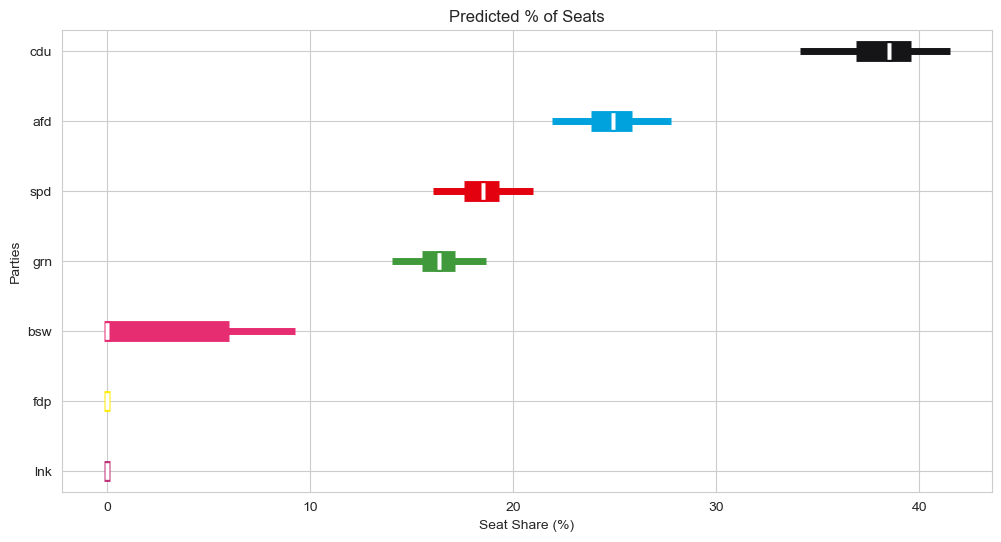

In [583]:
# Sort DataFrame by HDI50
chart_df = quantile_table.sort_values(by='HDI97')

# Initialize the figure
plt.figure(figsize=(12, 6))

# Plot each row with unique colors and at different heights
for i, (index, row) in enumerate(chart_df.iterrows()):
    y_position = i + 1  # Each row gets a different height

    # Assign color based on the party
    color = party_colors_map.get(index, 'gray')  # Default to gray if party color not found
    
    # Confidence interval lines (HDI3 to HDI97)
    plt.hlines(y=y_position, xmin=row['HDI3'], xmax=row['HDI97'], color=color, alpha=1, linewidth=5, zorder=5)
    
    # Middle confidence interval lines (HDI25 to HDI75)
    plt.hlines(y=y_position, xmin=row['HDI25'], xmax=row['HDI75'], color=color, alpha=1, linewidth=15, zorder=5)
    
    # The median value line (HDI50)
    plt.hlines(y=y_position, xmin=row['HDI50'] - 0.15, xmax=row['HDI50'] + 0.15, color=color, alpha=1, linewidth=15, zorder=5)
    plt.hlines(y=y_position, xmin=row['HDI50'] - 0.1, xmax=row['HDI50'] + 0.1, color='white', alpha=1, linewidth=12, zorder=5)

# Labels and title
plt.xlabel('Seat Share (%)')
plt.ylabel('Parties')
plt.title('Predicted % of Seats')

# Set the y-ticks to match the party names with corresponding y positions
plt.yticks(range(1, len(chart_df) + 1), chart_df.index)

# Show plot
plt.savefig('seat_share.png')

In [541]:
quantile_table

HDI3     HDI25     HDI50     HDI75     HDI97      Mode
bsw  0.019324  0.031591  0.040726  0.052204  0.080871  0.005561
lnk  0.024737  0.029193  0.031766  0.034512  0.039933  0.017890
grn  0.118773  0.130260  0.136340  0.142355  0.154428  0.104850
spd  0.136548  0.147945  0.154616  0.161418  0.174750  0.119775
oth  0.054491  0.062954  0.067916  0.073213  0.082651  0.044023
cdu  0.294552  0.311829  0.320329  0.328678  0.344174  0.263625
fdp  0.030354  0.034508  0.037110  0.039777  0.045609  0.024010
afd  0.186850  0.200102  0.207639  0.215719  0.230638  0.163333

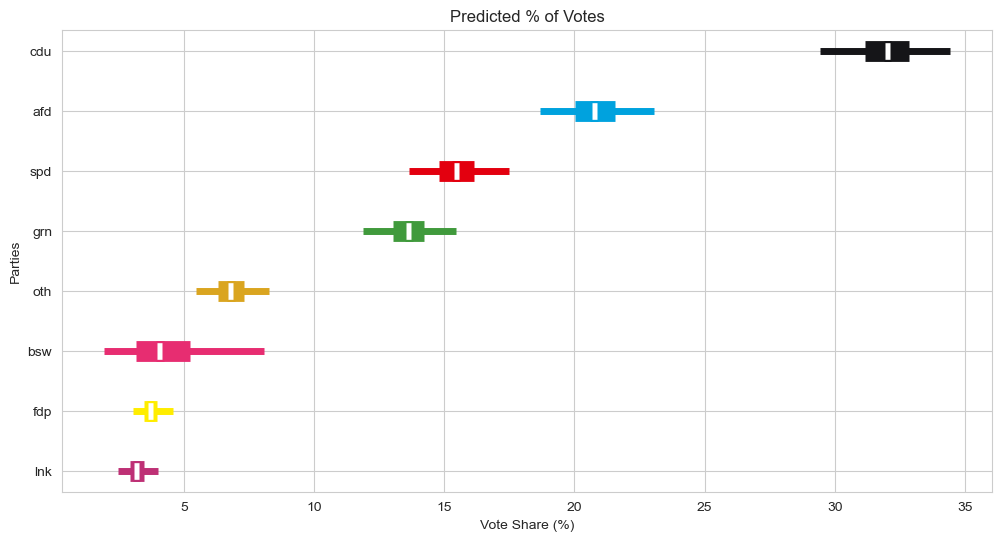

In [584]:
# List of quantiles to calculate
quantiles = [0.03, 0.25, 0.5, 0.75, 0.97]

# Calculate quantiles for each column
quantile_values = {f'HDI{int(100*q)}': (100*df_results).quantile(q) for q in quantiles}
quantile_table = pd.DataFrame(quantile_values)

# Sort DataFrame by HDI50
chart_df = quantile_table.sort_values(by='HDI50')

# Initialize the figure
plt.figure(figsize=(12, 6))

# Plot each row with unique colors and at different heights
for i, (index, row) in enumerate(chart_df.iterrows()):
    y_position = i + 1  # Each row gets a different height

    # Assign color based on the party
    color = party_colors_map.get(index, 'gray')  # Default to gray if party color not found
    
    # Confidence interval lines (HDI3 to HDI97)
    plt.hlines(y=y_position, xmin=row['HDI3'], xmax=row['HDI97'], color=color, alpha=1, linewidth=5, zorder=5)
    
    # Middle confidence interval lines (HDI25 to HDI75)
    plt.hlines(y=y_position, xmin=row['HDI25'], xmax=row['HDI75'], color=color, alpha=1, linewidth=15, zorder=5)
    
    # The median value line (HDI50)
    plt.hlines(y=y_position, xmin=row['HDI50'] - 0.15, xmax=row['HDI50'] + 0.15, color=color, alpha=1, linewidth=15, zorder=5)
    plt.hlines(y=y_position, xmin=row['HDI50'] - 0.1, xmax=row['HDI50'] + 0.1, color='white', alpha=1, linewidth=12, zorder=5)

# Labels and title
plt.xlabel('Vote Share (%)')
plt.ylabel('Parties')
plt.title('Predicted % of Votes')

# Set the y-ticks to match the party names with corresponding y positions
plt.yticks(range(1, len(chart_df) + 1), chart_df.index)

# Show plot
plt.savefig('vote_share.png')

In [585]:
quantile_table.to_csv()

HDI3      HDI25      HDI50      HDI75      HDI97
bsw   1.932377   3.159054   4.072641   5.220405   8.087137
lnk   2.473736   2.919341   3.176643   3.451188   3.993251
grn  11.877271  13.026019  13.633959  14.235485  15.442788
spd  13.654751  14.794497  15.461626  16.141780  17.475044
oth   5.449098   6.295410   6.791570   7.321280   8.265140
cdu  29.455190  31.182903  32.032885  32.867782  34.417371
fdp   3.035411   3.450762   3.711015   3.977650   4.560853
afd  18.684983  20.010249  20.763864  21.571863  23.063825

In [586]:
df_seats_pct.quantile(0.50)

bsw     0.000000
lnk     0.000000
grn    16.326531
spd    18.503401
cdu    38.503401
fdp     0.000000
afd    24.897959
Name: 0.5, dtype: float64

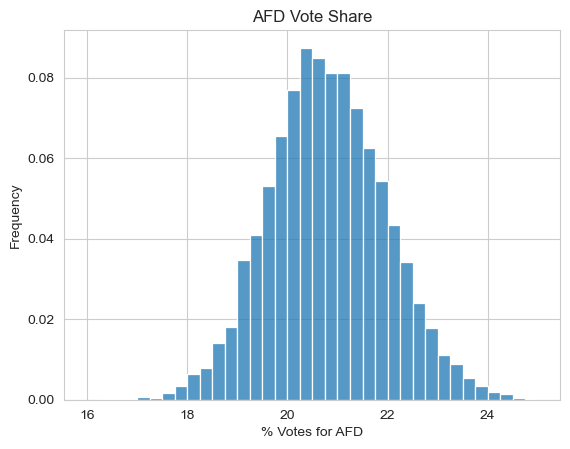

In [587]:
bin_width = 0.25
max_value = round(100 * df_results.afd.max())
min_value = round(100 * df_results.afd.min())

# Create bin edges starting at the minimum value and ending at the maximum value, with step size of 0.5
bin_edges = np.arange(min_value, max_value + bin_width, bin_width)

sns.histplot(100 * df_results.afd, bins=bin_edges, stat="probability")
plt.xlabel('% Votes for AFD')
plt.ylabel('Frequency')
plt.title('AFD Vote Share')

plt.savefig('afd_seats.png')

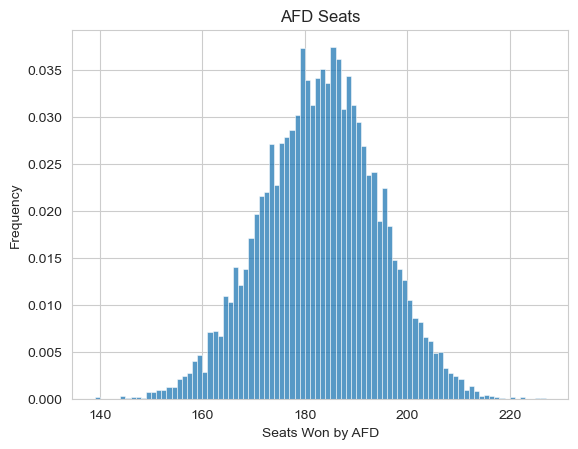

In [588]:
bin_width = 1
max_value = round(df_seats.afd.max())
min_value = round(df_seats.afd.min())

# Create bin edges starting at the minimum value and ending at the maximum value, with step size of 0.5
bin_edges = np.arange(min_value, max_value + bin_width, bin_width)

sns.histplot(df_seats.afd, bins=bin_edges, stat="probability")
plt.xlabel('Seats Won by AFD')
plt.ylabel('Frequency')
plt.title('AFD Seats')

plt.savefig('afd_seats.png')

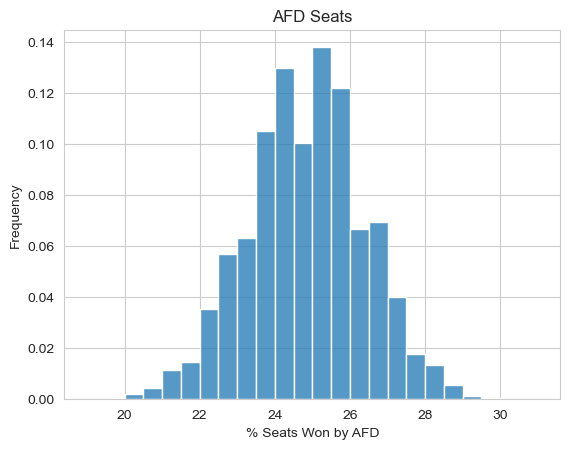

In [589]:
bin_width = 0.5
max_value = round(df_seats_pct.afd.max())
min_value = round(df_seats_pct.afd.min())

# Create bin edges starting at the minimum value and ending at the maximum value, with step size of 0.5
bin_edges = np.arange(min_value, max_value + bin_width, bin_width)

sns.histplot(df_seats_pct.afd, bins=bin_edges, stat="probability")
plt.xlabel('% Seats Won by AFD')
plt.ylabel('Frequency')
plt.title('AFD Seats')

plt.savefig('afd_seats.png')

Possibility of outright control of parliament

In [590]:
df_coalition = pd.DataFrame()

In [610]:
df_coalition = (df_seats_pct >= 50).astype(int)
df_coalition['grand'] = (df_seats_pct.cdu+df_seats_pct.spd >= 50).astype(int) #grand
df_coalition['black_green'] = (df_seats_pct.cdu+df_seats_pct.grn >= 50).astype(int)
df_coalition['black_yellow'] = (df_seats_pct.cdu+df_seats_pct.fdp >= 50).astype(int)
df_coalition['jamaica'] = ((df_seats_pct.cdu+df_seats_pct.grn+df_seats_pct.fdp >= 50) & (df_seats_pct.fdp >= 5)).astype(int)
df_coalition['traffic_light'] = (df_seats_pct.spd+df_seats_pct.grn+df_seats_pct.fdp >= 50).astype(int)

In [611]:
100*df_coalition.sum()/len(df_coalition)

bsw               0.00
lnk               0.00
grn               0.00
spd               0.00
cdu               0.00
fdp               0.00
afd               0.00
grand            99.70
black_green      94.47
black_yellow      0.00
jamaica           0.47
traffic_light     0.00
dtype: float64

In [593]:
df_coalition.corr()

bsw  lnk  grn  spd  cdu  fdp  afd     grand  black_green  \
bsw            NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN          NaN   
lnk            NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN          NaN   
grn            NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN          NaN   
spd            NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN          NaN   
cdu            NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN          NaN   
fdp            NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN          NaN   
afd            NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN          NaN   
grand          NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.000000     0.194725   
black_green    NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.194725     1.000000   
black_yellow   NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN          NaN   
jamaica        NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.164707     0.988463   
traffic_light  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN          NaN   

               black_yellow   jamaica  traffic_light  
bsw                     NaN       NaN            NaN  
lnk                     NaN       NaN            NaN  
grn                     NaN       NaN            NaN  
spd                     NaN       NaN            NaN  
cdu                     NaN       NaN            NaN  
fdp                     NaN       NaN            NaN  
afd                     NaN       NaN            NaN  
grand                   NaN  0.164707            NaN  
black_green             NaN  0.988463            NaN  
black_yellow            NaN       NaN            NaN  
jamaica                 NaN  1.000000            NaN  
traffic_light           NaN       NaN            NaN

In [594]:
#Source: https://python.plainenglish.io/how-to-create-a-parliamentary-hemicycle-data-visualization-in-python-331dd4306409

from collections import namedtuple, defaultdict

# Define the Party namedtuple
Party = namedtuple('Party', ['name', 'color', 'size'])

# Example of parties
parties2 = [Party(name, color, size) for name, color, size in zip(parties_wo, colors_wo, df_seats.mode().values.flatten().tolist())]

NUM_DEPUTIES = sum(p.size for p in parties2)

In [595]:
def calculate_radius(num_rows, initial_radius, radius_increment):
    """Calculate the radius for each row."""
    return [initial_radius + i * radius_increment for i in range(num_rows)]

def calculate_arc_lengths(radius):
    """Calculate the arc lengths for each radius."""
    return [r * np.pi for r in radius]

In [596]:
def calculate_deputies_per_row(num_deputies, arc_lengths, total_arc_length):
    """Calculate the number of deputies per row."""
    deputies_per_row = [int(num_deputies * (arc_length / total_arc_length)) for arc_length in arc_lengths]

    # Distribute the remaining deputies
    diff = num_deputies - sum(deputies_per_row)
    deputies_per_row[-1] += diff
    return deputies_per_row

In [597]:
def generate_points(num_rows, radii, deputies_per_row):
    """Generate the points for each deputy."""
    points = []
    for row in range(num_rows):
        radius = radii[row]
        num_deputies_row = deputies_per_row[row]
        angles = np.linspace(0, np.pi, num_deputies_row)  # Spread deputies across the semicircle
        x = radius * np.cos(angles)
        y = radius * np.sin(angles)
        for i in range(num_deputies_row):
            points.append((radius, angles[i], x[i], y[i]))
    return sorted(points, key=lambda x: x[1], reverse=True)

In [598]:
def main(num_rows, initial_radius, radius_increment):
    """Main function to generate deputies' positions."""
    radius = calculate_radius(num_rows, initial_radius, radius_increment)
    arc_lengths = calculate_arc_lengths(radius)
    total_arc_length = sum(arc_lengths)
    deputies_per_row = calculate_deputies_per_row(NUM_DEPUTIES, arc_lengths, total_arc_length)
    points = generate_points(num_rows, radius, deputies_per_row)

    Deputy = namedtuple('Deputy', ['x', 'y', 'radius', 'angle'])
    return [Deputy(x, y, radius, angle) for (radius, angle, x, y) in points]

In [604]:
def plot_deputies(deputies, parties, POINT_SIZE):
    """Plot the deputies on a chart."""
    deputies_by_party = defaultdict(list)

    current_index = 0

    for party in parties:
        party_deputies = deputies[current_index:current_index + party.size]
        deputies_by_party[party.name].extend(party_deputies)
        current_index += party.size

    deputies_by_party = dict(deputies_by_party)

    plt.figure(figsize=(12, 6))

    for party in parties:
        color = party.color
        party_deputies = deputies_by_party[party.name]

        label = party.name

        for deputy in party_deputies:
            if color == 'unassigned':
                plt.scatter(deputy.x, deputy.y, s=POINT_SIZE, facecolors='none', edgecolors='grey', linewidth=0.75, label=label)
            else:
                plt.scatter(deputy.x, deputy.y, s=POINT_SIZE, alpha=1, color=color, label=label)
            label = ""

    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.title('Predicted Bundestag Composition')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0) , ncol=6, frameon=False)

    plt.savefig('hemicycle.png')

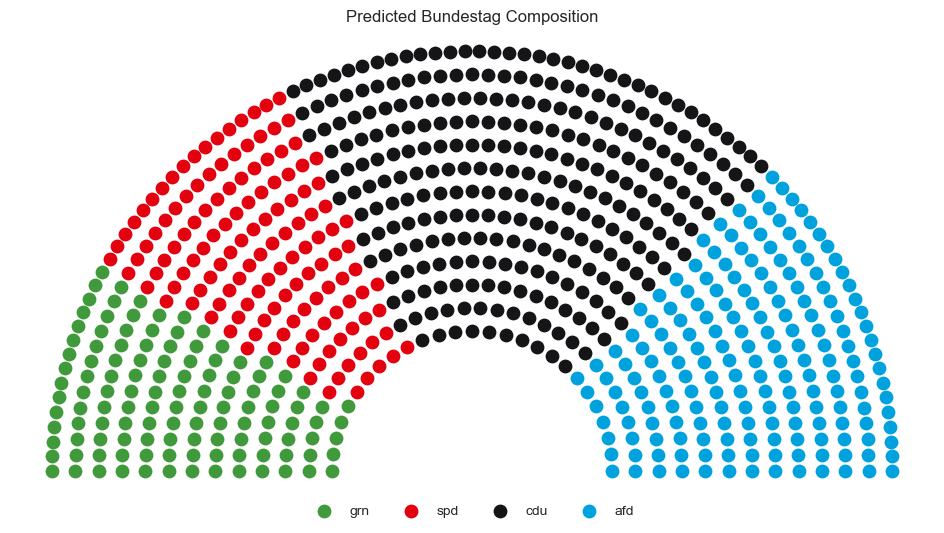

In [605]:
# Constants
NUM_ROWS = 13
INITIAL_RADIUS = 30
RADIUS_INCREMENT = 5
POINT_SIZE = 80

# Generate deputies and plot
deputies = main(NUM_ROWS, INITIAL_RADIUS, RADIUS_INCREMENT)
plot_deputies(deputies, parties2, POINT_SIZE)